# 과제1

## 이선우(20223888)

## Condition

$\$300000$ European Call Option > 100,000 shares of stock

$S_0 = 49$ <br>
$K = 50$ <br>
$r = 5\%$ <br>
$\sigma = 20\%$ <br>
$T = 20 weeks$ <br>
$\mu = 13\%$

## Code

In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
       
from scipy.stats import norm
from warnings import filterwarnings
filterwarnings('ignore')


In [192]:
class delta_hedging:

    def __init__(self, input):
 
        self.s0         = input['s0']               # 현재가격
        self.k          = input['k']                # 행사가격
        self.rf         = input['rf']               # 무위험이자율
        self.sigma      = input['sigma']            # 변동성
        self.mu         = input['mu']               # 평균수익률
        self.T          = input['T']                # 투자기간
        self.q          = input['q']                # 배당금 

        self.interval   = input['interval']         # T의 기간 텀
        self.time_step  = input['time_step']        # Investment Horizon
        self.simul      = input['simul_num']        # 시뮬레이션 횟수

        if self.interval == 'weekly':               
            self.dt = self.T / 52                   
        elif self.interval == 'daily':
            self.dt = self.T / 255
        
        self.tau        = self.time_step * self.dt
        self.tau_arr    = (np.flip(np.arange(0, self.time_step+1)) * self.dt).reshape(-1,1)

    def bs_call(self):
        d1 = (np.log(self.s0/self.k) +((self.rf - self.q +0.5*np.power(self.sigma, 2))*self.tau))/(self.sigma*np.sqrt(self.tau))
        d2 = d1 - self.sigma*np.sqrt(self.tau)
        value = self.s0*norm.cdf(d1) - self.k*np.exp(-self.rf*self.tau)*norm.cdf(d2)
        return value

    def stock_path(self):

        value = np.ones((2, self.simul)) * self.s0

        for idx in range(1, self.T * self.time_step + 1):
            d_term = (self.mu - self.q - 0.5 * self.sigma**2) * self.dt
            s_term = self.sigma * np.sqrt(self.dt) * np.random.normal(size=(self.simul))

            value = np.vstack([value, value[-1] * np.exp(d_term + s_term)])
            
        value = value[1:]

        return value

    def d1_cal (self, s, k, r, q, sigma, t):
        return (np.log(s/k) +((r+0.5*np.power(sigma, 2))*t))/(sigma*np.sqrt(t))

    def path_delta(self, stock_path=None):
        
        if stock_path is not None:
            path = stock_path
        else:
            path = self.stock_path()

        delta = norm.cdf(self.d1_cal(path, self.k, self.rf, self.q, self.sigma, self.tau_arr))
        
        return delta

    def hedging_cost(self, stock_path=None):

        if stock_path is not None:
            path = stock_path
        else:
            path = self.stock_path()

        delta = self.path_delta(path)
        path_arr = np.vstack([delta[0], (delta[1:] - delta[:-1])])
        
        hedge_arr = ((path_arr * path) * np.exp(self.rf * self.tau_arr)).cumsum(axis=0)[-1]
        hedge_arr = np.where(hedge_arr > self.k, hedge_arr - self.k, hedge_arr)

        return hedge_arr
            


## 1. Weekly

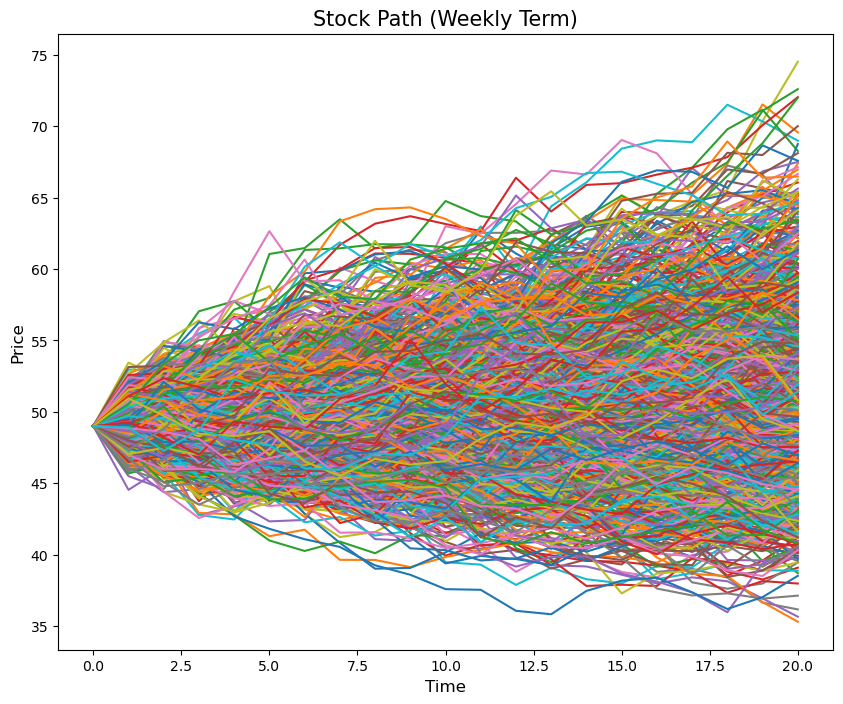

Hedging Cost (Weekly)
Mean = 2.445598157657994
Std = 0.485720464248418


In [193]:
'''Parameters'''
inputs = {
    's0' : 49,
    'k' : 50,
    'rf' : 0.05,
    'sigma' : 0.2,
    'T' : 1,
    'mu' : 0.13,
    'q' : 0,
    'interval' : 'weekly',
    'time_step' : 20,
    'simul_num' : 1000
}

dh = delta_hedging(inputs)
plt.figure(figsize=(10, 8), facecolor='w')
plt.plot(dh.stock_path()); plt.title('Stock Path (Weekly Term)', size=15); plt.ylabel('Price', size=12) ; plt.xlabel('Time', size=12); plt.show()

print('Hedging Cost (Weekly)')
print('Mean =', dh.hedging_cost().mean(), sep=' ')
print('Std =', dh.hedging_cost().std(), sep=' ')

## 2. Daily

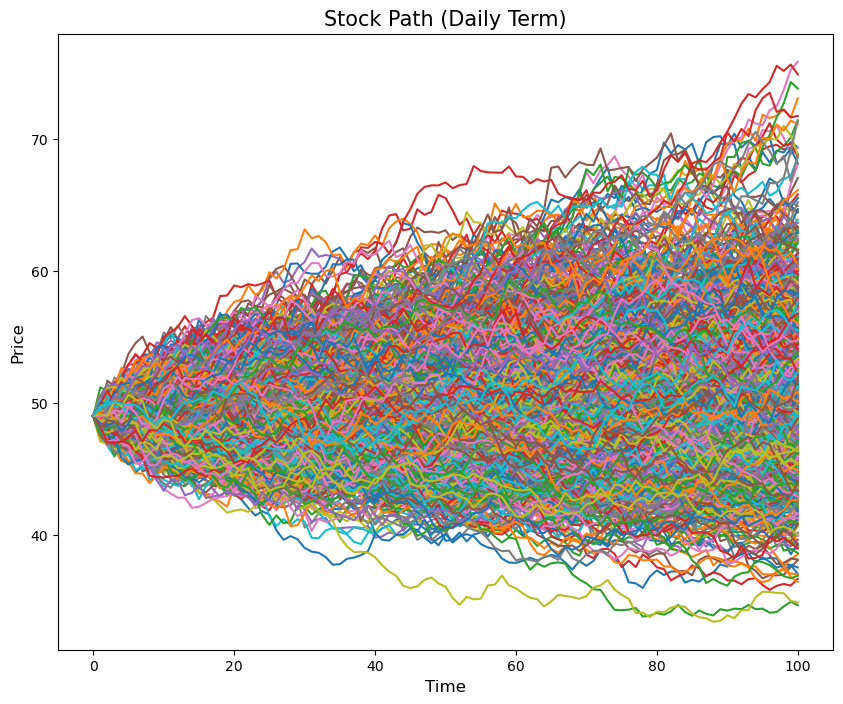

Hedging Cost (Daily)
Mean(Daily) = 2.491411671968535
Std(Daily) = 0.2223622983115051


In [194]:
'''Parameters'''
inputs = {
    's0' : 49,
    'k' : 50,
    'rf' : 0.05,
    'sigma' : 0.2,
    'T' : 1,
    'mu' : 0.13,
    'q' : 0,
    'interval' : 'daily',
    'time_step' : 100,              # 20 week 이므로 100 영업일
    'simul_num' : 1000
}

dh = delta_hedging(inputs)
plt.figure(figsize=(10, 8), facecolor='w')
plt.plot(dh.stock_path()); plt.title('Stock Path (Daily Term)', size=15); plt.ylabel('Price', size=12) ; plt.xlabel('Time', size=12); plt.show()

print('Hedging Cost (Daily)')
print('Mean(Daily) =', dh.hedging_cost().mean(), sep=' ')
print('Std(Daily) =', dh.hedging_cost().std(), sep=' ')